In [1]:
from matplotlib import pyplot as plt
from systemclass import SNAIL,SNAIL_sweep,Cavity, SNAILC, SNAILC_sweep, SNAILCC, SNAILCC_sweep
import numpy as np
from joblib import Parallel, delayed
import qutip as qt
from qutip import propagator,floquet_modes,Qobj,Options,basis
from scipy.optimize import fsolve
import numpy as np
def state_index(index,dim):
    m,n,k = index
    M,N,K = dim
    return m*(N*K)+n*K+k
def sort_eigenpairs(eigenvalues, eigenvectors):
    n = eigenvectors.shape[0]
    sorted_indices = []

    for i in range(n):
        max_abs_vals = np.abs(eigenvectors[i, :])
        max_index = np.argmax(max_abs_vals)
        while max_index in sorted_indices:
            max_abs_vals[max_index] = -np.inf
            max_index = np.argmax(max_abs_vals)
        sorted_indices.append(max_index)

    sorted_eigenvalues = eigenvalues[sorted_indices]
    sorted_eigenvectors = eigenvectors[:, sorted_indices]

    return sorted_eigenvalues, sorted_eigenvectors
    

def integral_of_pulse(max_amplitude, t0,t1,duration, target_area):
    func = gaussian_ramp(t0,t1, max_amplitude)
    t_values = np.linspace(0, duration, 10000)  # a dense grid for accuracy
    func_values = np.array([func(t) for t in t_values])
    func_values = func_values.reshape(10000)
    current_area = np.trapz(func_values, t_values)
    
    return current_area - target_area  # we want this to be zero

def find_max_amplitude(t0,t1,duration, target_area):
    # Initial guess for max_amplitude
    initial_guess = 1.0
    # Use fsolve to find the root, i.e., when integral_of_pulse returns 0
    max_amplitude, = fsolve(integral_of_pulse, initial_guess, args=(t0,t1,duration, target_area))
    return max_amplitude

def gaussian_ramp(t0,t1, amplitude):
    """
    Creates a time-dependent function using a Gaussian function that starts near zero,
    peaks at 'amplitude' at time 't0', and remains constant at 'amplitude' for t > t0.

    Args:
    t0 (float): The time at which the function peaks at the amplitude.
    amplitude (float): The maximum amplitude of the Gaussian peak.

    Returns:
    function: A function of time 't' that implements the desired behavior.
    """
    # Define the standard deviation such that the peak is sharp at t0
    sigma = t0 / 3  # Adjust sigma to make the function start close to zero at t=0
    
    offset = amplitude * np.exp(-((0 - t0)**2) / (2 * sigma**2))
    
    # Define the function using a closure to encapsulate the parameters
    def time_dependent_function(t):
        if t <= t0:
            # Gaussian function for ramp up
            return amplitude * np.exp(-((t - t0)**2) / (2 * sigma**2)) - offset
        elif t <= t1:
            # Constant amplitude between t0 and t1
            return amplitude - offset
        else:
            # Symmetric Gaussian function for ramp down
            return amplitude * np.exp(-((t - t1)**2) / (2 * sigma**2)) - offset

    return time_dependent_function

def energy_diff(t0,t1,duration,initial_duration,omega):
    flux =0.432
    #snail parameters
    EJ = 100*2*np.pi
    EC = 0.177*2*np.pi
    beta = 0.12
    ng = 0
    ncut = 300
    N = 3
    dims = 8
    snail = SNAIL(EJ,EC,beta,ng,ncut,flux,N,dims)
    Hs,charge_op = snail.spectrum_charge()


    #cavity1 parameters
    omega_c1 = 4.5*2*np.pi
    g_int1 = 0.15/2*(6-omega_c1/2/np.pi)*2*np.pi
    dimc1 = 4
    cavity1 = Cavity(omega_c1,g_int1,dimc1)

    #cavity1 parameters
    omega_c2 =  8.5*2*np.pi
    g_int2 = 0.15/2*(6-omega_c2/2/np.pi)*2*np.pi
    dimc2 = 4
    cavity2 = Cavity(omega_c2,g_int2,dimc2)

    Hc1, Vc1 = cavity1.hamiltonian()
    Hc2, Vc2 = cavity2.hamiltonian()

    Ic1 = np.identity(dimc1)
    Ic2 = np.identity(dimc2)
    Is = np.identity(dims)

    Hs = np.kron(np.kron(Hs,Ic1),Ic2)
    Hc1 = np.kron(np.kron(Is,Hc1),Ic2)
    Hc2 = np.kron(np.kron(Is,Ic1),Hc2)

    H_int1 = cavity1.g_int * np.kron(np.kron(charge_op,Vc1),Ic2) * 2 * ((2 * snail.EC / snail.EJ) ** 0.25)
    H_int2 = cavity2.g_int * np.kron(np.kron(charge_op,Ic1),Vc2) * 2 * ((2 * snail.EC / snail.EJ) ** 0.25)

    H = Hs + Hc1 + Hc2 + H_int1 + H_int2
    Hc  =  np.kron(np.kron(charge_op,Ic1),Ic2)
    energy0,U = np.linalg.eigh(H)
    energy0,U = sort_eigenpairs(energy0, U)
    Ud = U.transpose().conjugate()
    H = Ud@H@U
    Hc = Ud@Hc@U

    index1 = np.argmin(np.abs(energy0 - omega_c1 * np.ones(len(energy0))))
    index2 = np.argmin(np.abs(energy0 - omega_c2 * np.ones(len(energy0))))

    total_dim = dims*dimc1*dimc2
    H0 = Qobj(H)
    Hc = Qobj(Hc)
    psi0 = qt.basis(total_dim, index1)
    Iss = qt.qeye(dims)
    s0 = qt.basis(dims, 0)*(qt.basis(dims, 0).dag())
    cavity0 = qt.basis(dimc1, 0)*(qt.basis(dimc1, 0).dag())
    cavity1 = qt.basis(dimc1, 1)*(qt.basis(dimc1, 1).dag())
    cavity2 = qt.basis(dimc1, 2)*(qt.basis(dimc1, 2).dag())
    PP1 = qt.Qobj(np.array(qt.tensor(s0, cavity0, cavity1).full()))
    PP2 = qt.Qobj(np.array(qt.tensor(s0, cavity1, cavity0).full()))

    amplitude = find_max_amplitude(t0,initial_duration-t0,initial_duration,6700)
    func = gaussian_ramp(t0,t1, amplitude)
 
    args = {'w': omega}
    tlist = np.linspace(0, duration, 100000)  # Cover ten periods
    H = [H0, [Hc, lambda t, args: func(t)*np.cos(args['w']*t)]]

    result = qt.sesolve(H, psi0, tlist, args=args)
    exp_P1 = np.array([qt.expect(PP1, state) for state in result.states])
    exp_P2 = np.array([qt.expect(PP2, state) for state in result.states])
    return exp_P1,exp_P2

In [19]:
def annihilation(dim):
    return np.diag(np.sqrt(np.arange(1,dim)),1)
def creation(dim):
    return np.diag(np.sqrt(np.arange(1,dim)),-1)
dims = 8
sd = creation(dims)
s = annihilation(dims)
omega_s = 5*2*np.pi
g3 = 0.1*2*np.pi
Hs = omega_s*sd@s+g3*(s+sd)@(s+sd)@(s+sd)
Is = 1*np.identity(dims)
charge_op = -1j*(s-sd)


#cavity1 parameters
omega_c1 = 0.69*2*np.pi
g_int1 = 0.2/2*(6-omega_c1/2/np.pi)*2*np.pi
dimc1 = 2
cavity1 = Cavity(omega_c1,g_int1,dimc1)

#cavity1 parameters
omega_c2 =  0.43*2*np.pi
g_int2 = 0.2/2*(6-omega_c2/2/np.pi)*2*np.pi
dimc2 = 2
cavity2 = Cavity(omega_c2,g_int2,dimc2)

Hc1, Vc1 = cavity1.hamiltonian()
Hc2, Vc2 = cavity2.hamiltonian()

Ic1 = np.identity(dimc1)
Ic2 = np.identity(dimc2)
Is = np.identity(dims)

Hs = np.kron(np.kron(Hs,Ic1),Ic2)
Hc1 = np.kron(np.kron(Is,Hc1),Ic2)
Hc2 = np.kron(np.kron(Is,Ic1),Hc2)

H_int1 = cavity1.g_int * np.kron(np.kron(charge_op,Vc1),Ic2) * 2 * ((2 * snail.EC / snail.EJ) ** 0.25)
H_int2 = cavity2.g_int * np.kron(np.kron(charge_op,Ic1),Vc2) * 2 * ((2 * snail.EC / snail.EJ) ** 0.25)

H = Hs + Hc1 + Hc2 + H_int1 + H_int2
Hc  =  np.kron(np.kron(charge_op,Ic1),Ic2)
energy0,U = np.linalg.eigh(H)
energy0,U = sort_eigenpairs(energy0, U)
Ud = U.transpose().conjugate()
H = Ud@H@U
Hc = Ud@Hc@U

index1 = np.argmin(np.abs(energy0 - omega_c1 * np.ones(len(energy0))))
index2 = np.argmin(np.abs(energy0 - omega_c2 * np.ones(len(energy0))))

In [21]:
cavity1.g_int/2/np.pi

0.531

In [22]:
Hc[0,index2]

0.12301517615353084j

In [3]:
flux =0.432
#snail parameters
EJ = 100*2*np.pi
EC = 0.177*2*np.pi
beta = 0.12
ng = 0
ncut = 300
N = 3
dims = 8
snail = SNAIL(EJ,EC,beta,ng,ncut,flux,N,dims)
Hs,charge_op = snail.spectrum_charge()


#cavity1 parameters
omega_c1 = 4.5*2*np.pi
g_int1 = 0.15/2*(6-omega_c1/2/np.pi)*2*np.pi
dimc1 = 4
cavity1 = Cavity(omega_c1,g_int1,dimc1)

#cavity1 parameters
omega_c2 =  8.5*2*np.pi
g_int2 = 0.15/2*(6-omega_c2/2/np.pi)*2*np.pi
dimc2 = 4
cavity2 = Cavity(omega_c2,g_int2,dimc2)

Hc1, Vc1 = cavity1.hamiltonian()
Hc2, Vc2 = cavity2.hamiltonian()

Ic1 = np.identity(dimc1)
Ic2 = np.identity(dimc2)
Is = np.identity(dims)

Hs = np.kron(np.kron(Hs,Ic1),Ic2)
Hc1 = np.kron(np.kron(Is,Hc1),Ic2)
Hc2 = np.kron(np.kron(Is,Ic1),Hc2)

H_int1 = cavity1.g_int * np.kron(np.kron(charge_op,Vc1),Ic2) * 2 * ((2 * snail.EC / snail.EJ) ** 0.25)
H_int2 = cavity2.g_int * np.kron(np.kron(charge_op,Ic1),Vc2) * 2 * ((2 * snail.EC / snail.EJ) ** 0.25)

H = Hs + Hc1 + Hc2 + H_int1 + H_int2
Hc  =  np.kron(np.kron(charge_op,Ic1),Ic2)
energy0,U = np.linalg.eigh(H)
energy0,U = sort_eigenpairs(energy0, U)
Ud = U.transpose().conjugate()
H = Ud@H@U
Hc = Ud@Hc@U


In [6]:

index1 = np.argmin(np.abs(energy0 - omega_c1 * np.ones(len(energy0))))
index2 = np.argmin(np.abs(energy0 - omega_c2 * np.ones(len(energy0))))

In [11]:
Hc[1,4]

(1.3063364815877818e-12-0.0004851379810626978j)

In [328]:
find_max_amplitude(200,1200-200,1200,6700)/2/np.pi

1.1185443935505557

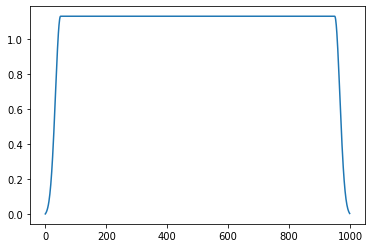

In [329]:
t0 = 50
initial_duration = 1000
t1 = t0+(initial_duration-t0-t0)
duration = t1+t0

amplitude = find_max_amplitude(t0,initial_duration-t0,initial_duration,6700)
func = gaussian_ramp(t0,t1, amplitude/2/np.pi)
t_values = np.arange(duration)
pulse_values = [func(t) for t in t_values]
plt.plot(t_values,pulse_values)

In [330]:
amplitude /2/np.pi

1.1459158455310345

In [331]:
sum(pulse_values)*2*np.pi

6699.997625504709

In [343]:
t0 = 50
initial_duration = 1000
t1 = (initial_duration-t0)
duration = t1+t0
t1s = np.linspace(t1-20, t1-10, 10)  # 11 points for 10 intervals
# Define the range for omega values, scaling by 2*pi
omega_values = np.linspace(4.01046,4.010475,5) * 2 * np.pi
# Use joblib to parallelize the calculation over both durations and omega values
results = Parallel(n_jobs=-1)(
    delayed(energy_diff)(t0,t1,t0+t1, initial_duration, omega)
    for t1 in t1s
    for omega in omega_values 
)


In [344]:
results = np.array(results)

In [345]:
results[:,0,-1].reshape(10,5)

array([[0.99975074, 0.99986817, 0.99989026, 0.99981701, 0.99964843],
       [0.99978558, 0.99990336, 0.99992552, 0.99985205, 0.99968296],
       [0.99981333, 0.99993147, 0.99995369, 0.99987999, 0.99971039],
       [0.999834  , 0.99995249, 0.99997478, 0.99990086, 0.99973076],
       [0.99984758, 0.99996642, 0.99998878, 0.99991464, 0.99974403],
       [0.99985409, 0.99997328, 0.9999957 , 0.99992134, 0.99975023],
       [0.9998535 , 0.99997304, 0.99999553, 0.99992095, 0.99974933],
       [0.99984583, 0.99996572, 0.99998828, 0.99991349, 0.99974136],
       [0.99983107, 0.99995132, 0.99997394, 0.99989893, 0.99972629],
       [0.99980924, 0.99992984, 0.99995252, 0.99987729, 0.99970415]])

In [346]:
omega_values/2/np.pi

array([4.01046   , 4.01046375, 4.0104675 , 4.01047125, 4.010475  ])

In [347]:
t1s

array([930.        , 931.11111111, 932.22222222, 933.33333333,
       934.44444444, 935.55555556, 936.66666667, 937.77777778,
       938.88888889, 940.        ])

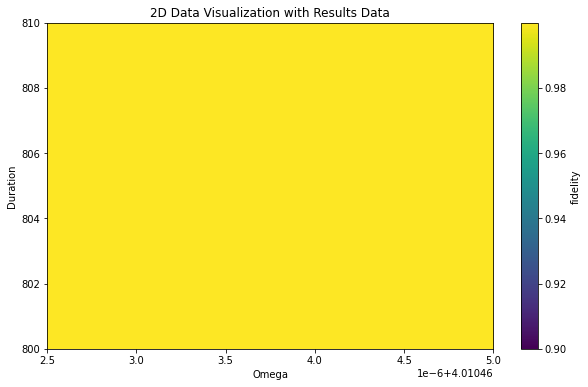

In [199]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming 'results' array as specified
data_slice = results[:, 0, -1].reshape(5, 10)
omega_values = np.linspace(4.0104625,4.010465,5) * 2 * np.pi
omega_values = omega_values/2/np.pi

# Creating the 2D plot using imshow
plt.figure(figsize=(10, 6))
# Transposing data_slice so that the x-axis (omega) and y-axis (duration) match correctly
im = plt.imshow(data_slice.T, aspect='auto', extent=[omega_values.min(), omega_values.max(), durations.min(), durations.max()], origin='lower', cmap='viridis',vmin = 0.99999)
plt.colorbar(im, label='fidelity')  # Add a colorbar to a plot
plt.xlabel('Omega')
plt.ylabel('Duration')
plt.title('2D Data Visualization with Results Data')
plt.show()

In [353]:

t0 = 50
initial_duration = 1000
t1 = (initial_duration-t0)
duration = 50
omega = 4.0104675*2*np.pi
flux =0.432
#snail parameters
EJ = 100*2*np.pi
EC = 0.177*2*np.pi
beta = 0.12
ng = 0
ncut = 300
N = 3
dims = 8
snail = SNAIL(EJ,EC,beta,ng,ncut,flux,N,dims)
Hs,charge_op = snail.spectrum_charge()


#cavity1 parameters
omega_c1 = 4.5*2*np.pi
g_int1 = 0.15/2*(6-omega_c1/2/np.pi)*2*np.pi
dimc1 = 4
cavity1 = Cavity(omega_c1,g_int1,dimc1)

#cavity1 parameters
omega_c2 =  8.5*2*np.pi
g_int2 = 0.15/2*(6-omega_c2/2/np.pi)*2*np.pi
dimc2 = 4
cavity2 = Cavity(omega_c2,g_int2,dimc2)

Hc1, Vc1 = cavity1.hamiltonian()
Hc2, Vc2 = cavity2.hamiltonian()

Ic1 = np.identity(dimc1)
Ic2 = np.identity(dimc2)
Is = np.identity(dims)

Hs = np.kron(np.kron(Hs,Ic1),Ic2)
Hc1 = np.kron(np.kron(Is,Hc1),Ic2)
Hc2 = np.kron(np.kron(Is,Ic1),Hc2)

H_int1 = cavity1.g_int * np.kron(np.kron(charge_op,Vc1),Ic2) * 2 * ((2 * snail.EC / snail.EJ) ** 0.25)
H_int2 = cavity2.g_int * np.kron(np.kron(charge_op,Ic1),Vc2) * 2 * ((2 * snail.EC / snail.EJ) ** 0.25)

H = Hs + Hc1 + Hc2 + H_int1 + H_int2
Hc  =  np.kron(np.kron(charge_op,Ic1),Ic2)
energy0,U = np.linalg.eigh(H)
energy0,U = sort_eigenpairs(energy0, U)
Ud = U.transpose().conjugate()
H = Ud@H@U
Hc = Ud@Hc@U

index1 = np.argmin(np.abs(energy0 - omega_c1 * np.ones(len(energy0))))
index2 = np.argmin(np.abs(energy0 - omega_c2 * np.ones(len(energy0))))

total_dim = dims*dimc1*dimc2
H0 = Qobj(H)
Hc = Qobj(Hc)
psi0 = qt.basis(total_dim, index1)
Iss = qt.qeye(dims)
s0 = qt.basis(dims, 0)*(qt.basis(dims, 0).dag())
cavity0 = qt.basis(dimc1, 0)*(qt.basis(dimc1, 0).dag())
cavity1 = qt.basis(dimc1, 1)*(qt.basis(dimc1, 1).dag())
cavity2 = qt.basis(dimc1, 2)*(qt.basis(dimc1, 2).dag())
PP1 = qt.Qobj(np.array(qt.tensor(s0, cavity0, cavity1).full()))
PP2 = qt.Qobj(np.array(qt.tensor(s0, cavity1, cavity0).full()))

amplitude = find_max_amplitude(t0,initial_duration-t0,initial_duration,6700)
func = gaussian_ramp(t0,t1, amplitude)

args = {'w': omega}
tlist = np.linspace(0, duration, 100000)  # Cover ten periods
H = [H0, [Hc, lambda t, args: func(t)*np.cos(args['w']*t)]]

result = qt.sesolve(H, psi0, tlist, args=args)
exp_P1 = np.array([qt.expect(PP1, state) for state in result.states])
exp_P2 = np.array([qt.expect(PP2, state) for state in result.states])

In [354]:
exp_P1

array([0.00000000e+00, 7.91506705e-25, 1.22978651e-23, ...,
       8.53383707e-04, 8.54068185e-04, 8.54819798e-04])

In [356]:
charge_op

array([[ 5.49560397e-15-5.55111512e-17j,  1.11092482e+00+9.03192932e-01j,
        -5.56384427e-02+1.20131527e-02j,  3.40538359e-03-6.95059410e-03j,
         1.69812609e-04+3.47599791e-04j, -1.80577822e-04-3.63983558e-05j,
         1.26988851e-05-1.12741263e-05j,  2.14291168e-10+2.43962021e-09j],
       [ 1.11092482e+00-9.03192932e-01j, -3.49720253e-14-5.55111512e-17j,
         1.58301628e+00+1.26844328e+00j, -8.90723905e-02+2.05792255e-02j,
        -6.15028525e-03+1.32789609e-02j,  4.00633194e-04+7.62599844e-04j,
        -4.24926897e-04-6.95062828e-05j,  2.78997106e-05-2.70662816e-05j],
       [-5.56384427e-02-1.20131527e-02j,  1.58301628e+00-1.26844328e+00j,
         7.82707232e-15+1.06492969e-50j,  1.95395196e+00+1.54236895e+00j,
         1.16602606e-01-2.87545158e-02j, -8.74813320e-03+2.00426182e-02j,
         7.27789769e-04+1.29083629e-03j, -7.64865351e-04-9.61381247e-05j],
       [ 3.40538359e-03+6.95059410e-03j, -8.90723905e-02-2.05792255e-02j,
         1.95395196e+00-1.54236895e